In this project, I delve into the challenging yet fascinating world of AI image detection, aiming to distinguish between real and AI-generated images. Utilizing the CASIA dataset from Kaggle, known for its diverse collection of real and AI-generated images, I seek to develop and refine a machine learning model that can effectively navigate this complex task.
Despite facing constraints in memory and dataset size, our goal is to push the boundaries of current AI capabilities in image recognition. This endeavor is not just about overcoming technical challenges; it's about exploring the potentials and expanding the horizons in the rapidly evolving domain of AI image detection. My journey through this project is set to provide valuable insights and pave the way for future advancements in this field.

---



#Loading Library



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageChops, ImageEnhance
import glob
import random
import os
import cv2
import tensorflow as tf
import io


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from tensorflow.keras.losses import categorical_crossentropy

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D, Dense, Flatten,Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

#Loading datasets from Kaggle

In [ ]:
#Installation de kaggle
#!pip install -q kaggle

from google.colab import files
files.upload()
#create a kaggle folder
!mkdir ~/.kaggle
#creation du dossier kaggle.json dans kaggle
!cp kaggle.json ~/.kaggle/
#Asking for the permission
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
#Download the dataset
!kaggle datasets download -d sophatvathana/casia-dataset
!unzip casia-dataset

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00008_nat10122_11773.jpg  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00045_arc00046_10084.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00045_arc00071_10087.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00046_arc00045_10083.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00054_cha00085_11922.jpg  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00071_arc00045_10085.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00073_arc00072_10267.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00088_arc00064_10394.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_art00012_art00013_11812.jpg  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_art00014_art00013_11836.jpg  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_art00058_art00049_10529.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani00093_11801.jpg  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani0009

#Data Visualization

In [ ]:
image_size=(128,128)
batch_size = 32
real_path = 'CASIA2/Au/'
fake_path = 'CASIA2/Tp/'

In [ ]:
def display_images(folder_path, title="Images", num_rows=3, num_cols=3):
    plt.figure(figsize=(7, 7))
    image_filenames = os.listdir(folder_path)
    random.shuffle(image_filenames)
    images_to_display = min(num_rows * num_cols, len(image_filenames))

    for i, filename in enumerate(image_filenames[:images_to_display]):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img,(224, 224))
        if img is not None:
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()


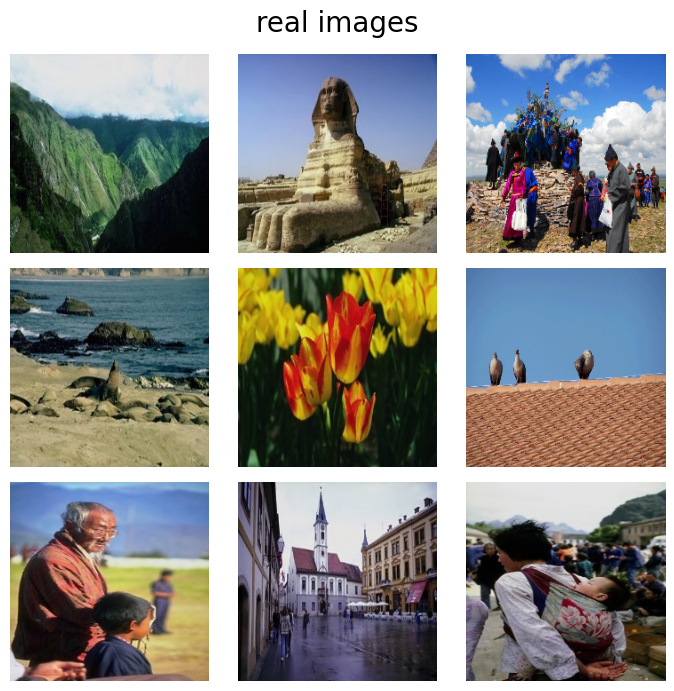

In [ ]:
display_images(real_path,"real images")

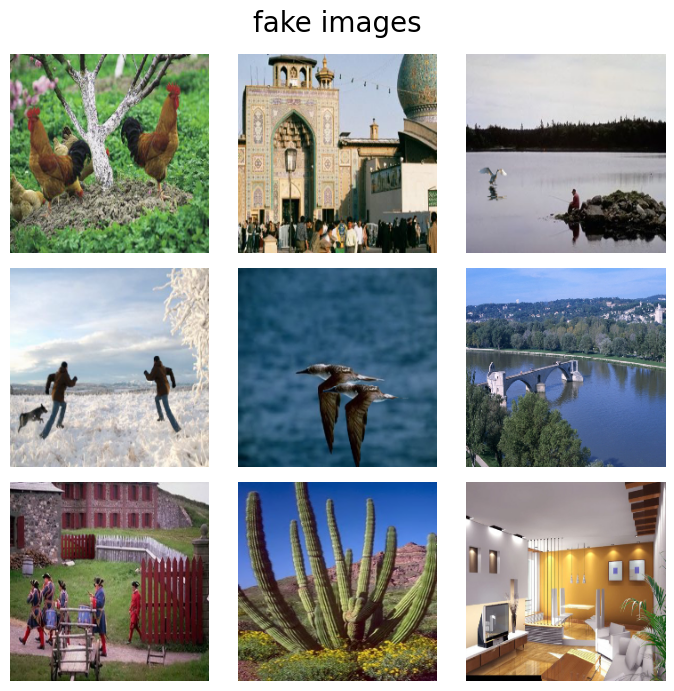

In [ ]:
display_images(fake_path ,"fake images")

By the way,fake images are defined as visuals artificially generated by computer algorithms, which can closely mimic the appearance of real photographs but are not created through conventional photography or manual artistic processes.

#Preprocessing Images


In our approach, we're employing ELA (Error Level Analysis) preprocessing. This technique is particularly effective for spotting generated or manipulated images as it highlights discrepancies in compression levels between altered and original areas. Essentially, ELA offers a visual means to pinpoint possible image alterations.

In [ ]:
def convert_to_ela_image(image_path, quality=90):
    temp_file = 'temp.jpg'
    im = Image.open(image_path).convert('RGB')
    im.save(temp_file, 'JPEG', quality=quality)

    # Open the saved image and the original image
    saved = Image.open(temp_file)
    orignal = Image.open(image_path)

    # Find the absolute difference between the images
    diff = ImageChops.difference(orignal, saved)

    # Normalize the difference by multiplying with a scale factor and convert to grayscale
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)

    # Remove the temporary file
    os.remove(temp_file)

    return diff

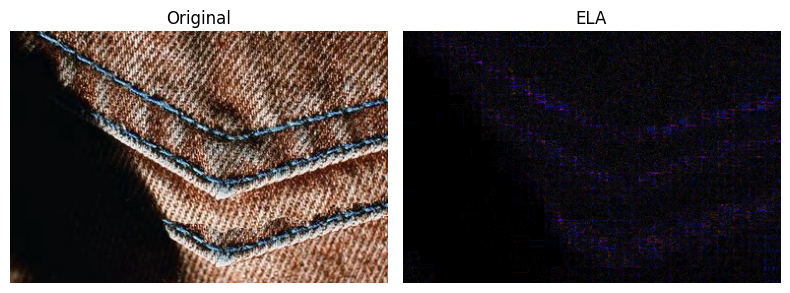

In [ ]:
# Examples
image_files = [os.path.join(fake_path, filename) for filename in os.listdir(fake_path) if filename.endswith(('.jpg', '.png', '.jpeg'))]
# Choose a random image file & Apply ELA
random_image_path = random.choice(image_files)
original, ela = cv2.imread(random_image_path ),convert_to_ela_image(random_image_path,95 )
plt.figure(figsize=(8, 4))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original")
plt.axis('off')

# Plot the ELA image
plt.subplot(1, 2, 2)
plt.imshow(ela, cmap='gray')
plt.title("ELA")
plt.axis('off')

#Plot Both images
plt.tight_layout()
plt.show()

Then we will use ImageDataGenerator for preprocessing. That transformations through ImageDataGenerator will essentially be used to the fake images, because we aim to accentuate their synthetic characteristics, enhancing the model's ability to distinguish them from real images by exaggerating the differences.

In [ ]:
#Choose a random image & resize
image_files = [os.path.join(fake_path, filename) for filename in os.listdir(fake_path) if filename.endswith(('.jpg', '.png', '.jpeg'))]
image_path = random.choice(image_files)
image = Image.open(image_path)
image = image.resize((224, 224))

# Convert the image to a numpy array with shape (1, height, width, channels)
image_array = np.array(image).reshape((1, *image.size, 3))

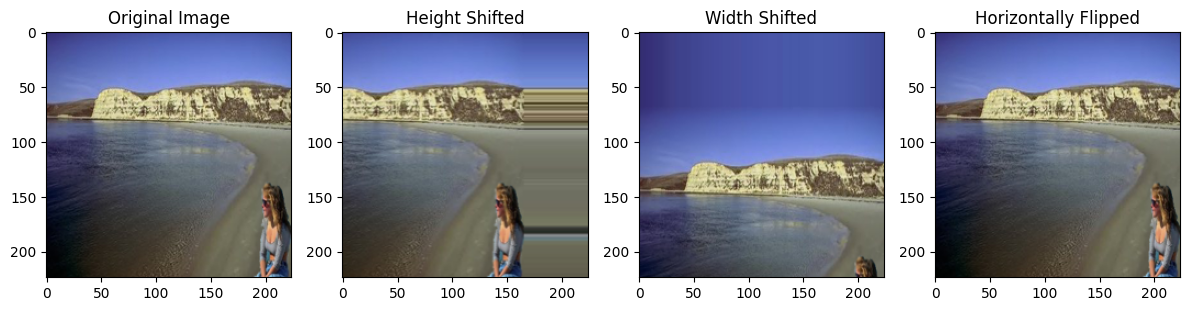

In [ ]:
# Create separate ImageDataGenerator instances
datagen_height = ImageDataGenerator(height_shift_range=0.3)
datagen_width = ImageDataGenerator(width_shift_range=0.3)
datagen_flip = ImageDataGenerator(horizontal_flip=True)

# Create iterators
it_height = datagen_height.flow(image_array, batch_size=1)
it_width = datagen_width.flow(image_array, batch_size=1)
it_flip = datagen_flip.flow(image_array, batch_size=1)

# Generate transformed images
image_height_shifted = it_height.next()[0].astype('uint8')
image_width_shifted = it_width.next()[0].astype('uint8')
image_flipped = it_flip.next()[0].astype('uint8')

# Plotting
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(image_array[0].astype('uint8'))
plt.title("Original Image")

# Height shifted image
plt.subplot(1, 4, 2)
plt.imshow(image_height_shifted)
plt.title("Height Shifted")

# Width shifted image
plt.subplot(1, 4, 3)
plt.imshow(image_width_shifted)
plt.title("Width Shifted")

# Horizontally flipped image
plt.subplot(1, 4, 4)
plt.imshow(image_flipped)
plt.title("Horizontally Flipped")

plt.tight_layout()
plt.show()




But for our data, we are going to use all these three transformations with ImageDataGenerator, the transformations are applied randomly and are not individually distinguishable in the output. This means for each image that goes through the generator, it might get a height shift, a width shift, a horizontal flip, or some combination of these, and this selection is random.

In [ ]:
datagen = ImageDataGenerator(height_shift_range=0.3,width_shift_range=0.3,horizontal_flip=True)

By the way, that process may add some noises but the noise added through ImageDataGenerator is not just random disruption but a strategic enhancement to the training process, enabling the model to better differentiate between real and fake images by learning to recognize the specific kinds of alterations and anomalies.

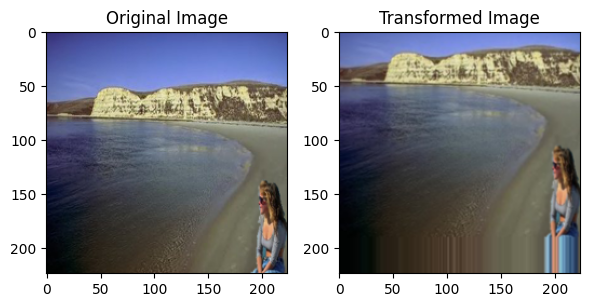

In [ ]:
# Create an iterator
it = datagen.flow(image_array, batch_size=1)

# Generate a single transformed image
batch = it.next()
image_transformed = batch[0].astype('uint8')

# Plotting
plt.figure(figsize=(6, 3))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image_array[0].astype('uint8'))
plt.title("Original Image")

# Transformed image
plt.subplot(1, 2, 2)
plt.imshow(image_transformed)
plt.title("Transformed Image")

plt.tight_layout()
plt.show()



The prepare_image processes an image at a given path by converting it to an ELA (Error Level Analysis) format, resizing it to a predefined size, flattening the array, and normalizing pixel values to the range [0, 1]

In [ ]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path).resize(image_size)).flatten() / 255.0

#Creation of train test and validation and test datasets

In [ ]:
X=[]    #Stores images
Y=[]    #Stores classification 1 for real, 0 for fake
X_augm=[] #For data augmentation

Creation of the train datasets with labels = 1 ( real_images), at the same time we aply ELA function

> Indented block



In [ ]:
folder = real_path
paths=glob.glob(folder+"*.jpg")
paths.append(glob.glob(folder+"*.png"))
paths=paths[0:4000]
random.shuffle(paths)
paths=paths[0:3000]
for path in paths:
    X.append(prepare_image(path))
    Y.append(1)
    if len(Y) % 500 == 0:
        print(f'Processing {len(Y)} images')

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images


\Creation of the train datasets with labels = 0 ( fake_images), at the same time we aply ELA function.

In [ ]:
folder = fake_path
paths=glob.glob(folder+"*.jpg")
paths.append(glob.glob(folder+"*.png"))
paths=paths[0:1000]
for path in paths:
    X_augm.append(prepare_image(path))


In [ ]:
samples = X_augm[0].reshape(1,128, 128, 3)
it = datagen.flow(samples, batch_size=1)

In [ ]:
for cnt,img in enumerate(X_augm):
    samples = img.reshape(1,128, 128, 3)
    it = datagen.flow(samples, batch_size=1)
    for i in range(3):
        batch = it.next()
        image = batch[0]
        X.append(image.flatten())
        Y.append(0)
    if (cnt+1)%250==0: print(f'Processing {cnt+1} images')

Processing 250 images
Processing 500 images
Processing 750 images
Processing 1000 images


In [ ]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.25, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size = 0.40, random_state=5)
print(f'No of elements in train dataset {len(X_train)}')
print(f'No of elements in test dataset {len(X_test)}')
print(f'No of elements in validation dataset {len(X_val)}')
print(f'Total no of elements {len(X)}')
X = X.reshape(-1,1,1,1)

No of elements in train dataset 4500
No of elements in test dataset 600
No of elements in validation dataset 900
Total no of elements 6000


#Implementation of the CNN model



In [ ]:
lr=1e-4
epochs = 10

In [ ]:
import tensorflow as tf
tf.compat.v1.reset_default_graph

def define_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr/epochs)  # Use legacy optimizer
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
model = define_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

#Prediction of the model

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/10
141/141 [==============================] - 18s 51ms/step - loss: 0.3777 - accuracy: 0.8116 - val_loss: 0.2209 - val_accuracy: 0.9311
Epoch 2/10
141/141 [==============================] - 6s 42ms/step - loss: 0.2138 - accuracy: 0.9342 - val_loss: 0.2354 - val_accuracy: 0.9133
Epoch 3/10
141/141 [==============================] - 6s 43ms/step - loss: 0.2004 - accuracy: 0.9360 - val_loss: 0.1906 - val_accuracy: 0.9311


In [ ]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_val,axis = 1)

29/29 [==============================] - 0s 11ms/step


In [ ]:
print(f'Training Loss: {hist.history["loss"][-1]}')
print(f'Validation Loss: {hist.history["val_loss"][-1]}')
print(f'Training Accuracy: {hist.history["accuracy"][-1]}')
print(f'Validation Accuracy: {hist.history["val_accuracy"][-1]}')
print(f'No of correct validation images: {np.sum(Y_true==Y_pred_classes)}')
print(f'No of incorrect validation images: {np.sum(Y_true!=Y_pred_classes)}')

Training Loss: 0.20038850605487823
Validation Loss: 0.19058379530906677
Training Accuracy: 0.9359999895095825
Validation Accuracy: 0.9311110973358154
No of correct validation images: 838
No of incorrect validation images: 62


In [ ]:
def summarize_diagnostics(history):
    fig,ax=plt.subplots(2)
    fig.suptitle("Loss")
    fig.tight_layout()
    # plot loss
    ax[0].set_title('Cross Entropy Loss')
    ax[0].plot(history.history['loss'], color='blue', label='Training loss')
    ax[0].plot(history.history['val_loss'], color='orange', label='validation loss')
    ax[0].legend(loc='best', shadow=True)
    # plot accuracy
    ax[1].set_title('Classification Accuracy')
    ax[1].plot(history.history['accuracy'], color='blue', label='train')
    ax[1].plot(history.history['val_accuracy'], color='orange', label='test')
    ax[1].legend(loc='best', shadow=True)

def print_confusion_metric(y_true, y_preds):
    cm = confusion_matrix(y_true, y_preds, normalize='all')
    cmd = ConfusionMatrixDisplay(cm, display_labels=['AI Image','Real Image'])
    cmd.plot()

Graphs:


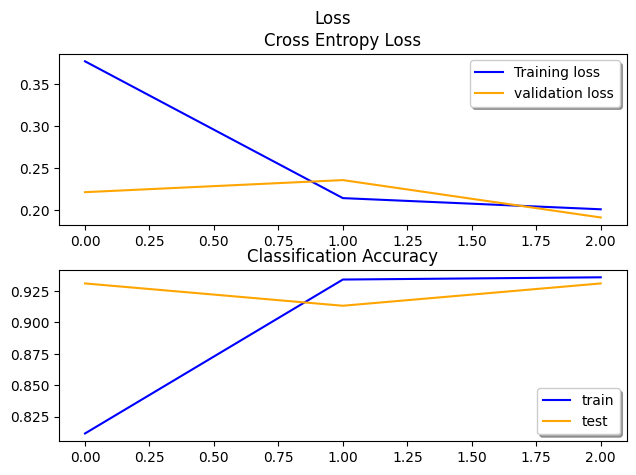

In [ ]:
print("Graphs:")
summarize_diagnostics(hist)

#Test of our model

In [ ]:
Ytest_pred = model.predict(X_test)
Ytest_pred_classes = np.argmax(Ytest_pred,axis = 1)
Ytest_true = np.argmax(Y_test,axis = 1)

19/19 [==============================] - 0s 23ms/step


In [ ]:
from tensorflow.keras.losses import categorical_crossentropy

# Calculate Accuracy
accuracy = np.mean(Ytest_pred_classes == Ytest_true)
# Calculate Loss
loss = categorical_crossentropy(Y_test, Ytest_pred).numpy().mean()
print(f'Training Accuracy: {hist.history["accuracy"][-1]}')
print(f'Validation Accuracy: {hist.history["val_accuracy"][-1]}')

Training Accuracy: 0.9359999895095825
Validation Accuracy: 0.9311110973358154


Test dataset confusion metrics:


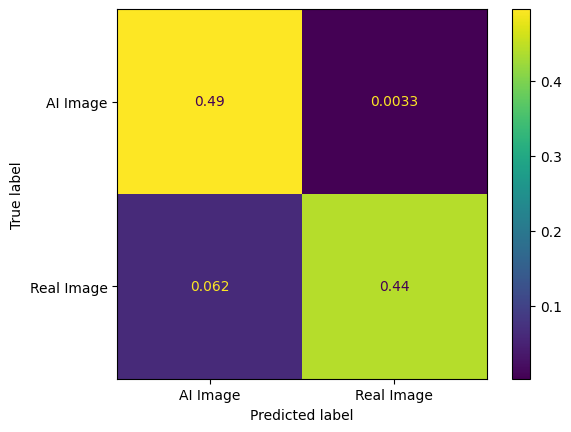

In [ ]:
print("Test dataset confusion metrics:")
print_confusion_metric(Ytest_true,Ytest_pred_classes)

Testing our models with images from our datasets

In [ ]:
class_names = ['Fake Image', 'Real Image']
folder="CASIA2"
paths=glob.glob(folder+"*/*/*.jpg")
paths.append(glob.glob(folder+"*.png"))

1/1 [==============================] - 0s 84ms/step



Confidence: 100.00
Predicted Class: Real Image
Actual Class: Real Image


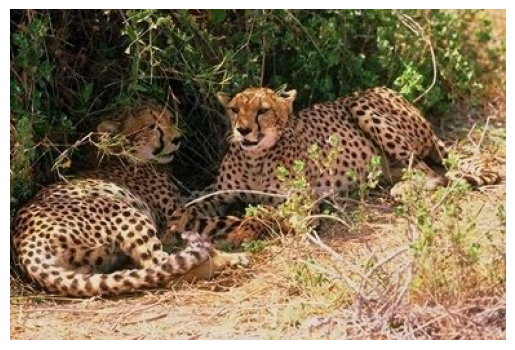

In [ ]:
path=random.choice(paths)

plt.imshow(Image.open(path))
plt.axis('off')
image = prepare_image(path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
y_true="Real Image" if ('Au' in path) else "Fake Image"

print("\n\n")
print(f'Confidence: {np.amax(y_pred) * 100:0.2f}')
print(f'Predicted Class: {class_names[y_pred_class]}')
print(f'Actual Class: {y_true}')

Limits of Our Model: In this section, we'll explore our model's performance when confronted with AI-generated images from advanced generators.

Saving midjourney.jpg to midjourney.jpg
1/1 [==============================] - 0s 23ms/step



Confidence: 88.23
Predicted Class: Fake Image


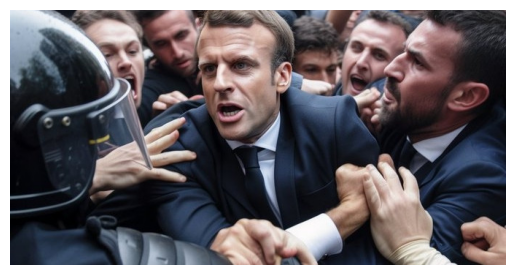

In [ ]:
#Examples
import io

# Upload an image file
uploaded = files.upload()
filename = next(iter(uploaded))

# Read the uploaded image file
path = io.BytesIO(uploaded[filename])
plt.imshow(Image.open(path))
plt.axis('off')
image = prepare_image(path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]

print("\n\n")
print(f'Confidence: {np.amax(y_pred) * 100:0.2f}')
print(f'Predicted Class: {class_names[y_pred_class]}')


The misclassification of the "Portrait_female_midjourney" image as real by our model highlights its limitations due to a smaller training dataset and underscores the sophistication of modern AI generators, capable of creating images that can more deceive the human eye.

#Limit of the model and conclusion

In concluding this project, we have navigated through significant challenges, particularly in terms of memory constraints and a limited dataset, which impacted our ability to handle extensive data. Despite these limitations, our model has shown remarkable resilience and efficiency. It achieved a high accuracy rate, a testament to its robustness in accurately classifying images. This was a notable accomplishment, especially in the context of the considerable resource gap we faced compared to advanced AI image generation tools like MidJourney, Stable Diffusion, DALL-E, and GPT-4, which benefit from much larger datasets.

A pivotal insight from our work was the recognition that many real-world images are not purely AI-generated but are often enhanced or filtered using AI. This realization adds a layer of complexity to the task of AI image detection, revealing the intricate interplay between AI-generated and AI-enhanced imagery in our digital landscape. This understanding has deepened our grasp of the challenges in creating an AI image detector capable of handling a diverse array of web images.

Reflecting on this journey, the experience has been invaluable. It has provided a clearer understanding of the potential and challenges inherent in AI image recognition. This project sets a solid foundation for further exploration and innovation in this rapidly evolving field. As we look forward, expanding our dataset and leveraging more robust computing resources will be key to enhancing our model and continuing our pursuit of advancements in AI image detection.



<h2><strong> Partie II </strong></h2>

In [ ]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
from PIL import Image
from torchvision import transforms
#Examples
import io

# Upload an image file
uploaded = files.upload()
filename = next(iter(uploaded))

# Read the uploaded image file

# Charger une image que vous souhaitez tester
path = io.BytesIO(uploaded[filename])
image = Image.open(path)

# Utiliser le processeur d'image pour prétraiter l'image
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
inputs = processor(images=image, return_tensors="pt")

# Charger le modèle pré-entraîné
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

# Obtenir les prédictions du modèle
with torch.no_grad():
    logits = model(**inputs).logits

# Prédire la classe de l'image
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])


FileNotFoundError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V3

# Create the ResNet-50V3 model
model = ResNet50V3(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the pre-trained weights
model.trainable = False

# Add a new dense layer on top of the ResNet-50V3 model
new_top = tf.keras.Sequential([
    layers.Flatten(input_shape=(224, 224, 3)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Connect the new top to the pre-trained ResNet-50V3 model
model = tf.keras.Model(inputs=model.input, outputs=new_top(model.output))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load our dataset
import tensorflow_datasets as tfds

mnist = tfds.load('mnist', split='train', as_supervised=True)

# Create the training and validation datasets
train_images = mnist.images
train_labels = mnist.labels

validation_images = mnist.validation.images
validation_labels = mnist.validation.labels

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=32, validation_data=(validation_images, validation_labels))

# Save the model
model.save('mnist_classifier.h5')